In [1]:
from datetime import datetime as dt
import unicodecsv

In [2]:
def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)
    
enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily_engagement.csv')
project_submissions = read_csv('project_submissions.csv')

In [3]:
# Takes a date as a string, and returns a Python datetime object
# If there is no date given, returns None

def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.

def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

In [4]:
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'TRUE'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'TRUE'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': False,
 u'is_udacity': False,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [5]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    engagement_record['account_key'] = engagement_record['acct']
    del[engagement_record['acct']]
    
daily_engagement[0]

{'account_key': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [6]:
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

In [7]:
def get_unique_students(data):
    unique_students = set()
    for data_point in data:
        unique_students.add(data_point['account_key'])
    return unique_students

In [8]:
len(enrollments)

1640

In [9]:
unique_enrolled_students = get_unique_students(enrollments)
len(unique_enrolled_students)

1302

In [10]:
len(daily_engagement)

136240

In [11]:
unique_engagement_students = get_unique_students(daily_engagement)
len(unique_engagement_students)

1237

In [12]:
len(project_submissions)

3642

In [13]:
unique_project_submitters = get_unique_students(project_submissions)
len(unique_project_submitters)

743

In [14]:
daily_engagement[0]['account_key']


u'0'

In [15]:
diff_student = []
for student in unique_enrolled_students:
    if student not in unique_engagement_students:
        diff_student.append(student)

len(diff_student)

65

In [16]:
count = 0
for enrollment in enrollments:
    if enrollment['days_to_cancel'] != 0 and enrollment['account_key'] not in unique_engagement_students:
        count += 1
count

3

In [17]:
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        print enrollment['account_key']
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

0

In [18]:
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [19]:
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagements = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagements)
print len(non_udacity_submissions)

1640
136240
3642


In [20]:
paid_students = {}
for enrollment in non_udacity_enrollments:
    if enrollment['days_to_cancel'] == None or \
    enrollment['days_to_cancel'] > 7:
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        
        if account_key not in paid_students or \
            enrollment_date > paid_students[account_key]:
                paid_students[account_key] = enrollment_date

len(paid_students)

999

In [21]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [22]:
def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data

paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trial_cancels(non_udacity_engagements)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

print len(paid_enrollments)
print len(paid_engagement)
print len(paid_submissions)

1309
135128
3626


In [23]:
paid_engagement_in_first_week = []

for engagement_record in paid_engagement:
    account_key = engagement_record['account_key']
    join_date = paid_students[account_key]
    engagement_record_date = engagement_record['utc_date']
    
    if within_one_week(join_date, engagement_record_date):
        paid_engagement_in_first_week.append(engagement_record)

    if engagement_record['num_courses_visited'] == 0:
        engagement_record['has_visited'] = 0
    else:
        engagement_record['has_visited'] = 1
        
len(paid_engagement_in_first_week)

6933

In [24]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

engagement_by_account = group_data(paid_engagement_in_first_week, 
                                   'account_key')



In [25]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)

def sum_grouped_items(grouped_data, field_name):
    
    summed_data= {}
    
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    
    return summed_data

total_minutes_by_account = sum_grouped_items(engagement_by_account,
                                            'total_minutes_visited')

Populating the interactive namespace from numpy and matplotlib
Mean: 306.179091737
Standard deviation: 412.755789151
Minimum: 0.0
Maximum: 3564.7332645


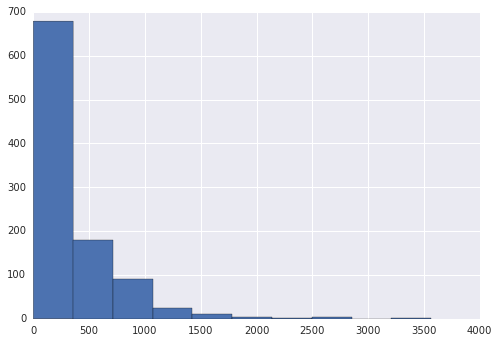

In [61]:
%pylab inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Summarize the data about minutes spent in the classroom
def describe_data(data):
    print 'Mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minimum:', np.min(data)
    print 'Maximum:', np.max(data)
    plt.hist(data)

total_minutes = total_minutes_by_account.values()
describe_data(total_minutes)

In [27]:
student_with_max_minutes = None
max_minutes = 0

for student, total_minutes in total_minutes_by_account.items():
    if total_minutes > max_minutes:
        max_minutes = total_minutes
        student_with_max_minutes = student
        
max_minutes

3564.7332644989997

In [28]:
for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] == student_with_max_minutes:
        print engagement_record

{u'lessons_completed': 4, u'num_courses_visited': 4, 'has_visited': 1, u'total_minutes_visited': 850.519339666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 9, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 6, 'has_visited': 1, u'total_minutes_visited': 872.633923334, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 10, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 2, 'has_visited': 1, u'total_minutes_visited': 777.018903666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 11, 0, 0)}
{u'lessons_completed': 2, u'num_courses_visited': 1, 'has_visited': 1, u'total_minutes_visited': 294.568774, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 12, 0, 0)}
{u'lessons_completed': 1, u'num_courses_visited': 3, 'has_visited': 1, u'total_minutes_visited': 471.2139785, u'projects_completed': 0, 'account_key': u'163

In [29]:
from collections import defaultdict

total_lessons_by_account = {}
for account_key, count_lessons in engagement_by_account.items():
    total_lessons = 0
    for engagement in count_lessons:
        total_lessons += engagement['lessons_completed']
    total_lessons_by_account[account_key] = total_lessons
    
# Summarize the data about lessons completed in the classroom
total_lessons = total_lessons_by_account.values()
print 'Mean:', np.mean(total_lessons)
print 'Standard deviation:', np.std(total_lessons)
print 'Minimum:', np.min(total_lessons)
print 'Maximum:', np.max(total_lessons)

Mean: 1.63289869609
Standard deviation: 3.00044144575
Minimum: 0
Maximum: 36


In [30]:
lessons_completed_by_account = sum_grouped_items(engagement_by_account,
                                                'lessons_completed')
describe_data(lessons_completed_by_account.values())

Mean: 1.63289869609
Standard deviation: 3.00044144575
Minimum: 0
Maximum: 36


In [31]:
days_visited_by_account = sum_grouped_items(engagement_by_account, 
                                            'has_visited')
describe_data(days_visited_by_account.values())

Mean: 2.86459378134
Standard deviation: 2.25476652377
Minimum: 0
Maximum: 7


In [32]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']

passing_submission = set()

for submission in paid_submissions:
    if submission['lesson_key'] in subway_project_lesson_keys and \
    submission['assigned_rating'] in ['PASSED', 'DISTINCTION']:
        passing_submission.add(submission['account_key'])

print len(passing_submission)

passing_engagement = []
non_passing_engagement = []

for engagement in paid_engagement_in_first_week:
    if engagement['account_key'] in passing_submission:
        passing_engagement.append(engagement)
        
    else:
        non_passing_engagement.append(engagement)
        
print len(passing_engagement)
print len(non_passing_engagement)

649
4541
2392


Mean: 393.502220982
Standard deviation: 448.238343086
Minimum: 0.0
Maximum: 3564.7332645

Mean: 143.326474267
Standard deviation: 269.538619011
Minimum: 0.0
Maximum: 1768.52274933

Mean: 2.04622496148
Standard deviation: 3.13944369346
Minimum: 0
Maximum: 36

Mean: 0.862068965517
Standard deviation: 2.54915994183
Minimum: 0
Maximum: 27

Mean: 3.37904468413
Standard deviation: 2.2592917225
Minimum: 0
Maximum: 7

Mean: 1.90517241379
Standard deviation: 1.90573144136
Minimum: 0
Maximum: 7


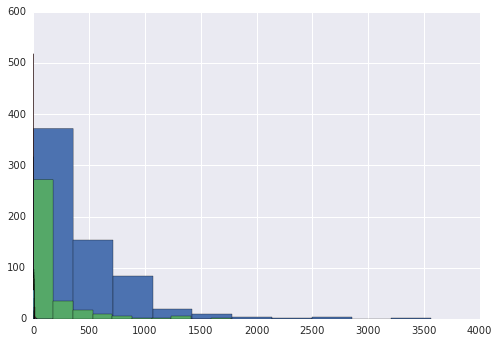

In [62]:
def find_meaning(data, field):
    data_dic = group_data(data, 'account_key')
    sum_data = sum_grouped_items(data_dic, field)
    return describe_data(sum_data.values())


find_meaning(passing_engagement,'total_minutes_visited')
print ''
find_meaning(non_passing_engagement,'total_minutes_visited')
print ''
find_meaning(passing_engagement,'lessons_completed')
print ''
find_meaning(non_passing_engagement, 'lessons_completed')
print ''
find_meaning(passing_engagement,'has_visited')
print ''
find_meaning(non_passing_engagement,'has_visited')



4541
2392
